NEXT JOURNAL
My first excusion in the Knoedler dataset gave us a very rough sense of when the dealer was most active, measured in terms of number of incoming and outgoing transactions. But another way to give us more insight into this question is to investigate the economics of it. We have a couple of variables to consider here: the amount the gallery paid, the amount sold, the amount gallery took (which should be the first less the second), and finally the currency of each of these transactions. If we wanted to be able to compare these transactions made using multiple currencies and made accross a centruy, we'd have to standardize the currency amount. So what I'm going to try to do is first convert each currency to dollars based on historical conversion rates and then convert resulting dollar amounts of each transation into present-day dollars, so that we can compare apples to apples.

First let's get a sense of how many different currencies we're dealing with so we can see. Do value counts and see what most frequenctly occuring ones are. Foir the sake of simplicity and to do a proof of concept I'm going to start with just converting a few most used currencies in their historical amounts using X tool. And I'm going to create new columns for this.

Then I'll have to find a site for inflation. Maybe there's a multiplier for each year and I can run the whole thing through a loop.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

knoedler = pd.read_csv('../data/knoedler.csv')


/Users/zrottman/miniconda3/envs/test/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (5,6,7,36,42,43,44,47,50,51,52,54,55,56,68,71,72,73,75,76,77,80,88) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


First, I'd like to get a sense of how many currencies we're dealing with.

There are eight relevant transaction categories in this dataset:
<ul>
    <li><code>purch_currency</code> and <code>purch_amount</code>: The total amount paid for the object and the currency of that transaction</li>
    <li><code>knoedpurch_curr</code> and <code>knoedpurch_amt</code>: Knoedler's share of the total purchase price and the currency</li>
    <li><code>price_currency</code> and <code>price_amount</code>: The total amount paid for the object by the buyer and the accompanying currency</li>
    <li><code>knoedshare_curr</code> and <code>knoedshare_amt</code>: Knoelder's share of the amount paid by the buyer and the accompanying currency</li>
</ul>

Now I need a better sense of how many of these transactions there are and how many currencies we're dealing with. This will give us a better sense of how to proceed.

In [30]:
# Isolate the columns of interest
currency_columns = ['purch_currency', 'knoedpurch_curr', 'price_currency', 'knoedshare_curr']

# Count up the values
knoedler[currency_columns].apply(pd.Series.value_counts)

,purch_currency,knoedpurch_curr,price_currency,knoedshare_curr
Swiss francs,1,NaN,NaN,NaN
dollar,1,NaN,NaN,NaN
dollars,18842,3704.0,22343.0,716.0
florins,215,2.0,14.0,NaN
francs,10954,282.0,657.0,43.0
lire,2,1.0,1.0,NaN
marks,2286,3.0,9.0,NaN
pounds,4989,1116.0,2168.0,156.0
thalers,345,NaN,NaN,NaN


Let's make this information a little more useful, first by consolidating the <code>dollar</code> and <code>dollars</code> categories, then by adding a columns that total each currency type, then by sorting the DataFrame in a useful way, and finally by adding totals for each column.

In [47]:
# Consolidate dollar/dollars
knoedler[knoedler.purch_currency == 'dollar'] = 'dollars'

# Create our new dataframe
currencies = knoedler[currency_columns].apply(pd.Series.value_counts)

# Total each row
currencies['total'] = currencies.sum(axis=1)

# Sort by totals
currencies.sort_values(by='total', ascending=False, inplace=True)

# Total each column
currencies.loc['total'] = currencies.sum(axis=0)

currencies

,purch_currency,knoedpurch_curr,price_currency,knoedshare_curr,total
dollars,18843.0,3705.0,22343.0,717.0,45608.0
francs,10954.0,282.0,657.0,43.0,11936.0
pounds,4989.0,1116.0,2168.0,156.0,8429.0
marks,2286.0,3.0,9.0,NaN,2298.0
thalers,345.0,NaN,NaN,NaN,345.0
florins,215.0,2.0,14.0,NaN,231.0
lire,2.0,1.0,1.0,NaN,4.0
Swiss francs,1.0,NaN,NaN,NaN,1.0
total,37635.0,5109.0,25192.0,916.0,68852.0


Now we're getting somewhere! We can see that the vast majority of transactions were denominated in Dollars, after which we see still substantial numbers of transactions denominated in Francs, Pounds, and Marks. Among other things, this immediately validates what we know to be Knoedler's primary markets: the United States, France, the United Kingdon, and Germany. Together, these four currencies comprise almost all of Knoedler's transactions, which means that, if we'd like to eventually denominate <i>all</i> transactions in present-day dollars (we would!), we need only perform the conversions for three currencies.

That's for later, however. For now, I want to get a visual sense of how these currencies break down over the various 
categories.

In [83]:
currencies.index.name = 'currency'
currencies.columns.name = 'transaction'
currencies

transaction,purch_currency,knoedpurch_curr,price_currency,knoedshare_curr,total
currency,,,,,
dollars,18843.0,3705.0,22343.0,717.0,45608.0
francs,10954.0,282.0,657.0,43.0,11936.0
pounds,4989.0,1116.0,2168.0,156.0,8429.0
marks,2286.0,3.0,9.0,NaN,2298.0
thalers,345.0,NaN,NaN,NaN,345.0
florins,215.0,2.0,14.0,NaN,231.0
lire,2.0,1.0,1.0,NaN,4.0
Swiss francs,1.0,NaN,NaN,NaN,1.0
total,37635.0,5109.0,25192.0,916.0,68852.0


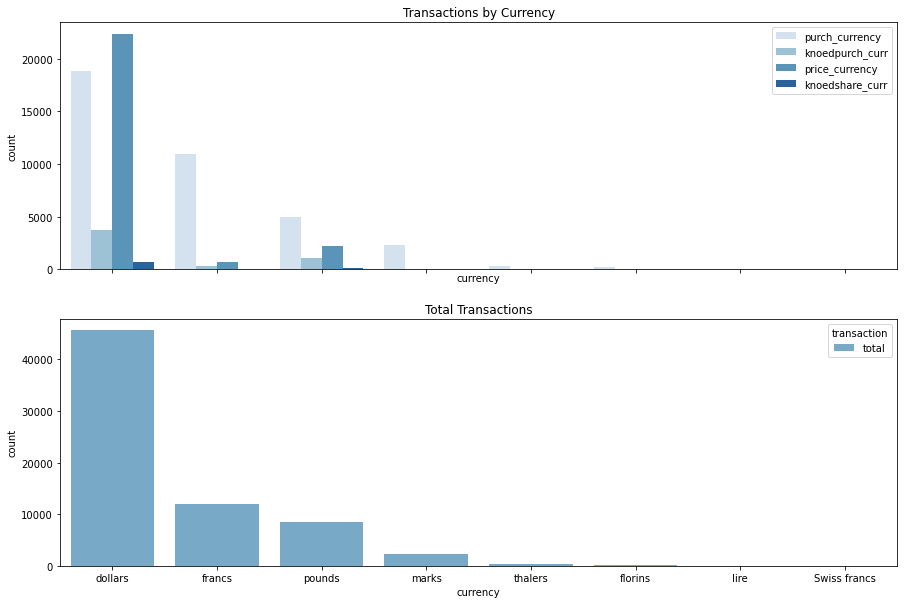

In [143]:
c = currencies.iloc[:-1].unstack()
c.columns = ['count']
c = pd.DataFrame(data=c, index=c.index, columns=['count'])
c = c.reset_index()

fig, axs = plt.subplots(2, 1, figsize=(15,10),sharex=True)
sns.barplot(data=c[c.transaction != 'total'], x='currency', y='count', hue='transaction', palette='Blues', dodge=True, ax=axs[0])
sns.barplot(data=c[c.transaction == 'total'], x='currency', y='count', hue='transaction', palette='Blues', ax=axs[1])
axs[0].set_title('Transactions by Currency')
axs[0].legend(loc='upper right')
axs[1].set_title('Total Transactions');

This is a good initial picture of what's happening in the data. We can clearly see that the majority of transactions indeed do occur in dollars. We can also see that instances where Knoedler shared a purchase or a sale (<code>knoedpurch_curr</code> and <code>knoedshare_curr</code>) are rare. And the last thing that's noteable is that, while there are substantial numbers of purchases made in Francs, Pounds, and Marks, it is far rarer to see sales made in these currencies. This again confirms what we already know: that Knoedler was a U.S. dealer that seems to have regularly made purchases in Europe but done most of its selling stateside.

Some questions that emerge from here:
- is it indeed true that transactions made in non-dollar denominations tended to be sold in dollars? what is the probability that a transaction made in a given currency is sold in dollars?

Once we normalize transactions in presentd day deollars:
- how did knoelders profits change over time?
- how did its buying and selling change over time as measured not by number of objects but on financial flows?

In [ ]:
transaction_columns = ['purch_amount', 'knoedpurch_amt', 'price_amount', 'knoedshare_amt']
